# Generating Stories and Story ideas with Cohere and Stable Diffusion

Describe your story in two sentences, then guide Cohere's language model as it turns it into a bigger story.

Your story description, called the log line, will then be used to generate the story title, characters, plot, location descriptions, and scene dialog. This is done with a different prompt for each of these components.

This notebook follows the method and prompts described in the paper [Co-Writing Screenplays and Theatre Scripts with Language Models: An Evaluation by Industry Professionals](https://www.deepmind.com/publications/co-writing-screenplays-and-theatre-scripts-with-language-models-an-evaluation-by-industry-professionals) by Piotr Mirowski, Kory Mathewson, Jaylen Pittman, Richard Evans.

![https://i.imgur.com/IcHfYhw.png](https://i.imgur.com/IcHfYhw.png)



In [ ]:
!pip install stability-sdk cohere

In [2]:
#@title Import Cohere, set up some things { display-mode: "form" }

import cohere
import time
import pandas as pd
import re
import io
import os
import warnings
from IPython.display import display
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation
import getpass, os


# Paste your API key here. Remember to not share it publicly 
os.environ['COHERE_KEY'] = getpass.getpass('Enter your Cohere API Key')
co = cohere.Client(os.environ['COHERE_KEY'])

# To get your API key, visit https://beta.dreamstudio.ai/membership
os.environ['STABILITY_KEY'] = getpass.getpass('Enter your Dream Studio API Key')

def generate(prompt, model="xlarge", num_generations=5, temperature=0.7, max_tokens=50, stop_sequences=['<end>']):
  prediction = co.generate(
    model=model,
    prompt=prompt,
    return_likelihoods = 'GENERATION',
    stop_sequences=stop_sequences,
    max_tokens=max_tokens,
    temperature=temperature,
    num_generations=num_generations)
  
  # Get list of generations
  gens = []
  likelihoods = []
  for gen in prediction.generations:
      gens.append(gen.text)
      
      sum_likelihood = 0
      for t in gen.token_likelihoods:
          sum_likelihood += t.likelihood
      # Get sum of likelihoods
      likelihoods.append(sum_likelihood)

  pd.options.display.max_colwidth = 200
  # Create a dataframe for the generated sentences and their likelihood scores
  df = pd.DataFrame({'generation':gens, 'likelihood': likelihoods})
  # Drop duplicates
  df = df.drop_duplicates(subset=['generation'])
  # Sort by highest sum likelihood
  df = df.sort_values('likelihood', ascending=False, ignore_index=True)
  
  return df


stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], 
    verbose=True,
)


def generate_image(image_prompt):
  # the object returned is a python generator
  answers = stability_api.generate(
      prompt=image_prompt
  )

  # iterating over the generator produces the api response
  for resp in answers:
      for artifact in resp.artifacts:
          if artifact.finish_reason == generation.FILTER:
              warnings.warn(
                  "Your request activated the API's safety filters and could not be processed."
                  "Please modify the prompt and try again.")
          if artifact.type == generation.ARTIFACT_IMAGE:
              img = Image.open(io.BytesIO(artifact.binary))
              display(img)


Enter your Cohere API Key··········
Enter your Dream Studio API Key··········


INFO:stability_sdk.client:Opening channel to grpc.stability.ai:443
INFO:stability_sdk.client:Channel opened to grpc.stability.ai:443


## Story Summary
All we have to do is write a story summary. The model generates the rest.

This brief description is called the log line.

In [3]:
log_line = """Scifi cyberpunk story about two hackers who find themselves both 
the targets of a cyber intelligence agent who suspects them of stealing $3.5 
million worth of Bitcoin. The two do not know each other, and neither of them 
recalls stealing the sum."""

In [4]:
#@title Generate Title Suggestions { display-mode: "form" }

prompt_title_scifi = """Examples of alternative, original and descriptive titles for known play and film scripts.

Example 1. A science - fiction fantasy about a naive but ambitious farm boy from a backwater desert who
discovers powers he never knew he had when he teams up with a feisty princess, a mercenary space pilot
and an old wizard warrior to lead a ragtag rebellion against the sinister forces of the evil Galactic
Empire. Title: The Death Star's Menace <end>

Example 2. Residents of San Fernando Valley are under attack by flying saucers from outer space. The
aliens are extraterrestrials who seek to stop humanity from creating a doomsday weapon that could
destroy the universe and unleash the living dead to stalk humans who wander into the cemetery looking
for evidence of the UFOs. The hero Jeff, an airline pilot, will face the aliens. Title: The Day The
Earth Was Saved By Outer Space. <end>

Example 3. {LOG_LINE} Title:"""

prompt = prompt_title_scifi.format(LOG_LINE=log_line)

titles = generate(prompt, temperature=1, max_tokens=20)
titles

,generation,likelihood
0,Two Bit's Worth. <end>,-15.115971
1,Decrypting The Hacker <end>,-16.252393
2,A Pair Of Dead Hackers. <end>,-19.469429
3,Data - Killers. <end>,-20.493583
4,Don't Get Stuck In The Outbox. <end>,-26.152514


In [5]:
#@title Generate Characters and Description

character_prompt_scifi = """
Example 1. A science fiction fantasy about a naive but ambitious farm boy from a backwater desert who
discovers powers he never knew he had when he teams up with a feisty princess, a mercenary space pilot
and an old wizard warrior to lead a ragtag rebellion against the sinister forces of the evil Galactic
Empire.
Characters and descriptions:
<character> Luke Skywalker <description> Luke Skywalker is the hero. A naive farm boy, he will discover
special powers under the guidance of mentor Ben Kenobi. <stop>
<character> Ben Kenobi <description> Ben Kenobi is the mentor figure. A recluse Jedi warrior, he will
take Luke Skywalker as apprentice. <stop>
<character> Darth Vader <description> Darth Vader is the antagonist. As a commander of the evil Galactic
Empire, he controls space station The Death Star. <stop>
<character> Princess Leia <description> Princess Leia is a feisty and brave leader of the Rebellion. She
holds the plans of the Death Star. She will become Luke's friend. <stop>
<character> Han Solo <description> Han Solo is a brash mercenary space pilot of the Millenium Falcon and
a friend of Chebacca. He will take Luke on his spaceship. <stop>
<character> Chewbacca <description> Chewbacca is a furry and trustful monster. He is a friend of Han
Solo and a copilot on the Millemium Falcon. <stop>
<end>
Example 2. {LOG_LINE}.
Characters and descriptions:"""

prompt = character_prompt_scifi.format(LOG_LINE=log_line)

titles = generate(prompt, num_generations=3, temperature=1, max_tokens=500)

for idx, gen in enumerate(titles['generation'].values):
  print(f"============")
  print(f"Generation {idx}")
  print(gen)

# Which generation to pick?
gen_idx = 0
gen = titles['generation'].values[gen_idx]

character_descriptions = re.findall('\<description\>\s(.*?)\s<stop>', gen, re.DOTALL)
character_names = re.findall('\<character\>\s(.*?)\s<description>', gen, re.DOTALL)

Generation 0

<character> Howard (pseudonym) <description> Howard is a professional Bitcoin hacker. <stop>
<character> Max (pseudonym) <description> Max is a professional hacker, whose client was recently hacked.
He asks Howard to look into the matter. <stop>
<character> Nick (pseudonym) <description> Nick is a Cyber Intelligence Agent of the Feds. <stop>
<character> Lise (pseudonym) <description> Lise is Max's partner in crime. <stop>
<end>
Generation 1

<character> John Doe #1 <description> John Doe #1 is a teenager from the UK. A cyberpunk
hacker who enjoys finding bugs in code. He works at the defunct mobile phone company
GPS and develops his own programs. <stop>
<character> Jane Doe #2 <description> Jane Doe #2 is a single mother from San Francisco. A cyberpunk
hacker who enjoys making malware. She works at a security company and hacks for fun. <stop>
<end>
Generation 2

<character> Anna Jackson <description> An African-American hacker, in her early 30s. Anna works in
Downtown Chi

In [6]:
character_descriptions

['Howard is a professional Bitcoin hacker.',
 'Max is a professional hacker, whose client was recently hacked.\nHe asks Howard to look into the matter.',
 'Nick is a Cyber Intelligence Agent of the Feds.',
 "Lise is Max's partner in crime."]

## Visualize Characters with Stable Diffusion

Now that we have character descriptions, we can generate possible images showing them. We can get some style descriptions from Lexica.art.

In [7]:
# Get character style prompts from https://lexica.art/?q=cyberpunk
character_style_1 = """portrait futuristic cyberpunk, in heavy rainning 
futuristic tokyo rooftop cyberpunk night, ssci-fi, fantasy, intricate, very very 
beautiful, elegant, neon light, highly detailed, digital painting, artstation, 
concept art, soft light, hdri, smooth, sharp focus"""

character_style_2 = """detailed portrait Neon Operator, cyberpunk 
futuristic neon, reflective puffy coat, decorated with traditional 
Japanese ornaments by Ismail inceoglu dragan bibin hans thoma greg rutkowski 
Alexandros Pyromallis Nekro Rene Maritte Illustrated, Perfect face, fine details,
 realistic shaded, fine-face, pretty face"""

INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got keepalive e71266c1-80f7-4cdf-8c4c-72c2d1695e30 in 0.16s


Max is a professional hacker, whose client was recently hacked.
He asks Howard to look into the matter. portrait futuristic cyberpunk, in heavy rainning 
futuristic tokyo rooftop cyberpunk night, ssci-fi, fantasy, intricate, very very 
beautiful, elegant, neon light, highly detailed, digital painting, artstation, 
concept art, soft light, hdri, smooth, sharp focus


INFO:stability_sdk.client:Got keepalive e71266c1-80f7-4cdf-8c4c-72c2d1695e30 in 3.01s
INFO:stability_sdk.client:Got e71266c1-80f7-4cdf-8c4c-72c2d1695e30 with ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 0.23s


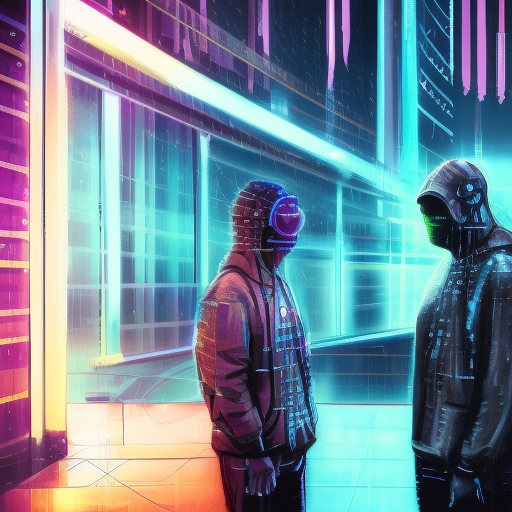

INFO:stability_sdk.client:Sending request.


None


INFO:stability_sdk.client:Got keepalive 17900276-1e5c-4783-91a9-04ef411015fa in 1.00s
INFO:stability_sdk.client:Got keepalive 17900276-1e5c-4783-91a9-04ef411015fa in 3.14s
INFO:stability_sdk.client:Got 17900276-1e5c-4783-91a9-04ef411015fa with ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 0.24s


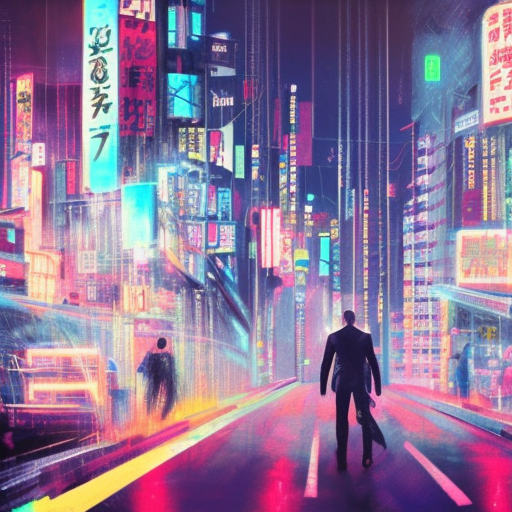

INFO:stability_sdk.client:Sending request.


None


INFO:stability_sdk.client:Got keepalive 21c32d95-29e6-4fba-af29-c80caa7d97b4 in 1.02s
INFO:stability_sdk.client:Got keepalive 21c32d95-29e6-4fba-af29-c80caa7d97b4 in 3.14s
INFO:stability_sdk.client:Got 21c32d95-29e6-4fba-af29-c80caa7d97b4 with ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 0.22s


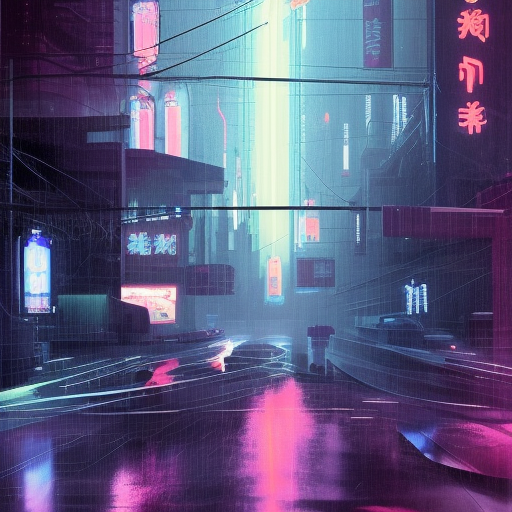

None


In [11]:

image_prompt_character_1 = f'{character_descriptions[1]} {character_style_1}'
print(image_prompt_character_1)

# Generate images
for i in range (3):
  print(generate_image(image_prompt_character_1))

INFO:stability_sdk.client:Sending request.
INFO:stability_sdk.client:Got keepalive 16cdeb23-9e20-4638-858e-b0b716bbd554 in 2.65s
INFO:stability_sdk.client:Got keepalive 16cdeb23-9e20-4638-858e-b0b716bbd554 in 3.10s
INFO:stability_sdk.client:Got 16cdeb23-9e20-4638-858e-b0b716bbd554 with ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 0.21s


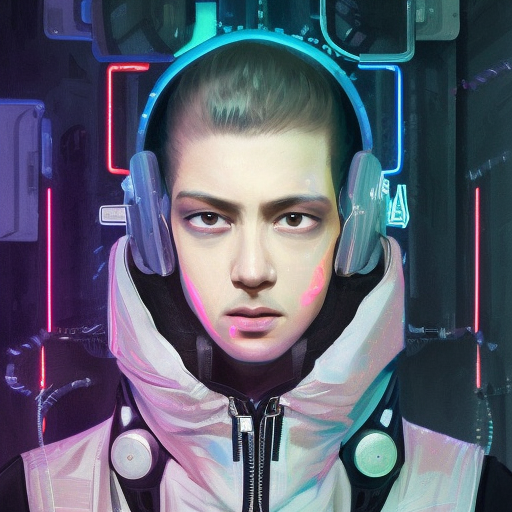

In [13]:
image_prompt_character_2 = f'{character_descriptions[2]} {character_style_2}'
image_prompt_character_2

generate_image(image_prompt_character_2)

## Narrative Structure

![https://i.imgur.com/Rkxvlmp.png](https://i.imgur.com/Rkxvlmp.png)

In [15]:
#@title Generate Story Beats

story_structure = """
Examples of breakdowns of stories into a Hero 's Journey structure.

Example 1. A science - fiction fantasy about a naive but ambitious farm boy from a backwater desert who
discovers powers he never knew he had when he teams up with a feisty princess, a mercenary space pilot
and an old wizard warrior to lead a ragtag rebellion against the sinister forces of the evil Galactic
Empire.
Luke Skywalker is the hero. A naive farm boy, he will discover special powers under the guidance of
mentor Ben Kenobi.
Ben Kenobi is the mentor figure. A recluse Jedi warrior, he will take Luke Skywalker as apprentice.
Darth Vader is the antagonist. As a commander of the evil Galactic Empire, he controls space station
The Death Star.
Princess Leia holds the plans of the Death Star. She is feisty and brave. She will become Luke 's
friend.
Han Solo is a brash mercenary space pilot of the Millenium Falcon and a friend of Chebacca. He will
take Luke on his spaceship.
Chewbacca is a furry and trustful monster. He is a friend of Han Solo and a copilot on the Millemium
Falcon.

<scenes>

Place: A farm on planet Tatooine.
Plot element: 1- The Ordinary World.
Beat: Luke Skywalker is living a normal and humble life as a farm boy on his home planet.

Place: Desert of Tatooine.
Plot element: 2- Call to Adventure.
Beat: Luke is called to adventure by Ben Kenobi, who tells him about his Jedi heritage and suggests he come with them.

Place: A farm on planet Tatooine.
Plot element: 3- Refusal of the Call.
Beat: Luke initially refuses to leave his Aunt and Uncle behind for an adventure in space.

Place: A farm on planet Tatooine.
Plot element: 4- Crossing the First Threshold.
Beat: Luke is forced to join the adventure when he discovers his Aunt and Uncle have been killed by the Empire and he has nowhere else to go.

Place: On spaceship The Millennium Falcon.
Plot element: 5- The Approach to the Inmost Cave.
Beat: The group's plan to defeat the Empire and bring the Death Star plans to the Rebellion is thwarted when they arrive at Alderaan and find the planet destroyed. They are pulled into the Death Star by a tractor beam.

Place: On space station The Death Star.
Plot element: 6- The Ordeal and The Reward.
Beat: The group faces challenges on the Death Star, including rescuing Princess Leia and escaping, and Kenobi sacrificing himself. They are successful in retrieving the Death Star plans, giving them the knowledge to destroy the Empire's weapon.

<end>
Example 2. {LOG_LINE}
{CHARACTER_DESCRIPTIONS}
<scenes>"""

character_descriptions_prompt_section = "\n".join(character_descriptions)
prompt = story_structure.format(LOG_LINE=log_line, 
                                CHARACTER_DESCRIPTIONS=character_descriptions_prompt_section)

titles = generate(prompt, 
                  num_generations=1, temperature=1.1, max_tokens=500)

for idx, gen in enumerate(titles['generation'].values):
  print(f"============")
  print(f"Generation {idx}")
  print(gen)

beat_sections = re.findall('(Place.*?)\n\n', gen, re.DOTALL)
# beat_sections

df = pd.DataFrame(columns=['place', 'plot_element', 'beat'])
story_beats = []
for beat_section in beat_sections:
  # print(f'==\n{beat_section}')
  place = re.findall('Place:\s(.*?)\.\n', beat_section, re.DOTALL)
  plot_element = re.findall('Plot element:\s(.*?)\.\n', beat_section, re.DOTALL)
  beat= re.findall('Beat: (.*?)\.', beat_section, re.DOTALL)
  story_beats.append({'place':place[0], 'plot_element': plot_element[0], 'beat':beat[0]})


place_names = re.findall('Place:\s(.*?)\.\nPlot element:', gen, re.DOTALL)
plot_elements = re.findall('Plot element:\s(.*?)\.\n', gen, re.DOTALL)

place_names = pd.Series(place_names).unique()


Generation 0


Place: Office building in New York.
Plot element: 1- The Ordinary World.
Beat: Howard works in a grubby office as a professional Bitcoin hacker.

Place: Laundromat in Brooklyn.
Plot element: 2- Call to Adventure.
Beat: Max asks Howard to hack his client's account and discover who was behind the hack.

Place: A public Wi-Fi network.
Plot element: 3- Refusal of the Call.
Beat: Howard is hesitant to take on the case, because he has an important audition.

Place: Laundromat in Brooklyn.
Plot element: 4- Crossing the First Threshold.
Beat: Howard accepts the case and meets Max in person.

Place: Internet café.
Plot element: 5- The Approach to the Inmost Cave.
Beat: Howard meets Nick and learns of Lise.

Place: A park.
Plot element: 6- The Ordeal and The Reward.
Beat: Howard and Max both become targets of Nick's investigation, but they do not know why.

<end>



## Location Description
Let's now generate a description for each place mentioned in the story structure.

In [16]:
#@title Generate location descriptions

# Updated prompt. Switched "Description" to "Place description"
place_prompt = """
Example 1. Morgan adopts a new cat, Misterio, who sets a curse on anyone that pets them.
Place: The Adoption Center.
Place Description: The Adoption Center is a sad place, especially for an unadopted pet. It is full of walls
and walls of cages and cages. Inside of each is an abandoned animal, longing for a home. The lighting
is dim, gray, buzzing fluorescent. <end>

Example 2. James finds a well in his backyard that is haunted by the ghost of Sam.
Place: The well.
Place Description: The well is buried under grass and hedges. It is at least twenty feet deep , if not more
and it is masoned with stones. It is 150 years old at least. It stinks of stale, standing water, and
has vines growing up the sides. It is narrow enough to not be able to fit down if you are a grown
adult human. <end>

Example 3. Mr. Dorbenson finds a book at a garage sale that tells the story of his own life. And it
ends in a murder!
Place: The garage sale.
Place Description: It is a garage packed with dusty household goods and antiques. There is a box at the back
that says FREE and is full of paper back books. <end>

Example 4. {LOG_LINE}
Place: {LOCATION_NAME}.
Place Description:"""

location_descriptions = []
for location in place_names:

  prompt = place_prompt.format(LOG_LINE=log_line, 
                                LOCATION_NAME=location)

  location_description = generate(prompt, num_generations=1, temperature=1, max_tokens=100)['generation']
  print(f'location: {location}')
  print(f'generated description: {location_description.values[0]}\n\n')
  location_descriptions.append(location_description.values[0])

# location_descriptions

location: Office building in New York
generated description:  The offices are shabby, mostly vacant, and have only the most rudimentary security
measures. There is one office that is not quite empty. The two hackers are at the office
door. <end>


location: Laundromat in Brooklyn
generated description:  A grimy, damp basement, with low ceilings, grimy yellowed tiles, and grey 
concrete floor. The smell of detergent and soap hangs in the air. The launderette 
is deserted, and all of the machines are broken. <end>


location: A public Wi-Fi network
generated description:  A busy network that a person can log into to check their email, etc. It is open to the
public and there are lots of people using it. There is also a security warning that pops up that tells
you that the network is not secure and to be careful. <end>


location: Internet café
generated description:  A dimly lit, dirty-carpeted room full of old computers and cables.


Now, if I were to ask someone for a description of pla

In [17]:
# https://lexica.art/prompt/86975be7-69c1-4aed-b95f-8d24b0df2537
room_style_1 = """ultra mega super hyper realistic Digital concept interior design.
stone walls and neon lights, a lot of electronics. Natural white 
sunlight from the transperient roof. Rendered in VRAY and  DaVinci Resolve and 
MAXWELL and LUMION 3D, Volumetric natural light"""

INFO:stability_sdk.client:Sending request.


shabby, mostly vacant offices. Two hackers are at the office
door. ultra mega super hyper realistic Digital concept interior design.
stone walls and neon lights, a lot of electronics. Natural white 
sunlight from the transperient roof. Rendered in VRAY and  DaVinci Resolve and 
MAXWELL and LUMION 3D, Volumetric natural light


INFO:stability_sdk.client:Got keepalive a572398f-2445-40b1-960e-da7cc76f585a in 2.23s
INFO:stability_sdk.client:Got keepalive a572398f-2445-40b1-960e-da7cc76f585a in 3.08s
INFO:stability_sdk.client:Got a572398f-2445-40b1-960e-da7cc76f585a with ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 0.21s


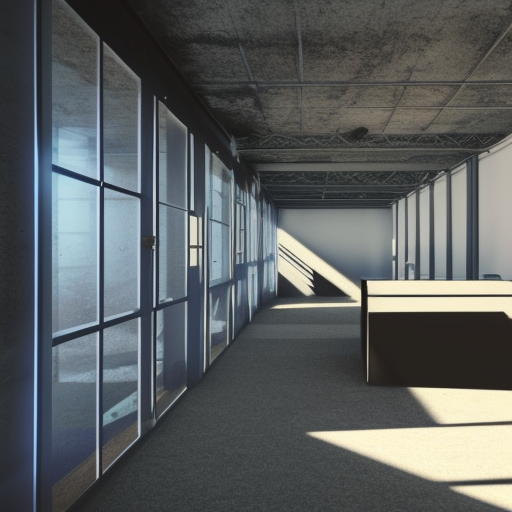

INFO:stability_sdk.client:Sending request.


None


INFO:stability_sdk.client:Got keepalive 7d2ac518-1d76-4e3a-b13b-f13cb05eaaee in 3.76s
INFO:stability_sdk.client:Got keepalive 7d2ac518-1d76-4e3a-b13b-f13cb05eaaee in 2.88s
INFO:stability_sdk.client:Got 7d2ac518-1d76-4e3a-b13b-f13cb05eaaee with ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 0.20s


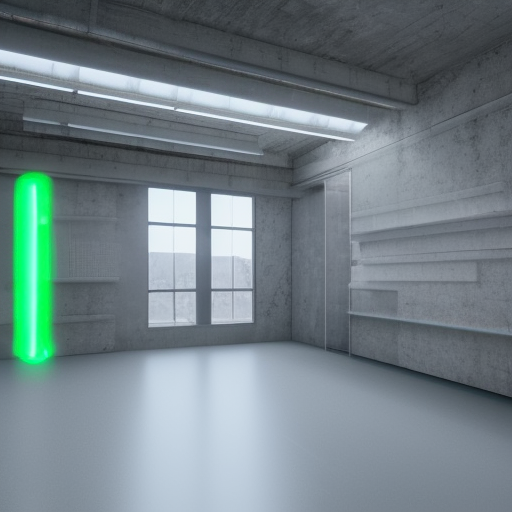

INFO:stability_sdk.client:Sending request.


None


INFO:stability_sdk.client:Got keepalive acd1498c-a514-4a18-823e-b3139aa20e98 in 3.30s
INFO:stability_sdk.client:Got keepalive acd1498c-a514-4a18-823e-b3139aa20e98 in 3.10s
INFO:stability_sdk.client:Got acd1498c-a514-4a18-823e-b3139aa20e98 with ['ARTIFACT_IMAGE', 'ARTIFACT_CLASSIFICATIONS', 'ARTIFACT_LATENT'] in 0.21s


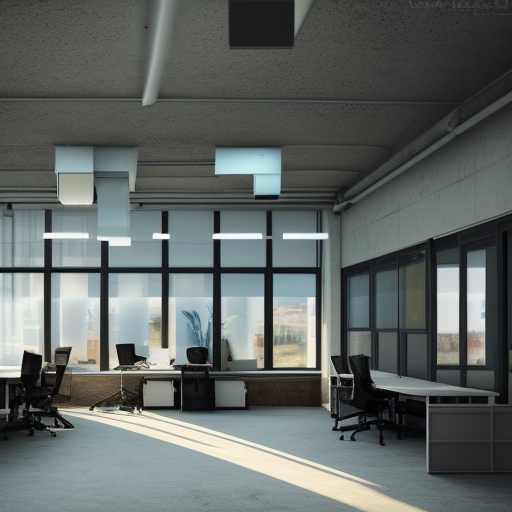

None


In [20]:
location_description = location_descriptions[0]
location_description = """shabby, mostly vacant offices. Two hackers are at the office
door."""

image_prompt_room_1 = f'{location_description} {room_style_1}'
print(image_prompt_room_1)

# Generate images
for i in range (3):
  print(generate_image(image_prompt_room_1))

In [64]:
#@title Generate Dialog for scenes

dialog_prompt ="""Example 1.
Place : Cockpit of an airplane.
Description: Cockpit of a modern passenger airplane , American Flight 812.
Characters: Jeff is the hero. A man in his early forties, he tries to stay calm in all circumstance.
Jeff is now a airline pilot. Danny, a young airplane pilot in his thirties, is eager to learn but can
quickly lose his composture. Danny is enamored of Edith. Edith, an experienced stewardess with a good
sense of humour, is trustworthy and dependable. Edith likes to tease Danny.
Plot element: Crossing the First Threshold.
Summary: Residents of San Fernando Valley are under attack by flying saucers from outer space. The
aliens are extraterrestrials who seek to stop humanity from creating a doomsday weapon that could
destroy the universe and unleash the living dead to stalk humans who wander into the cemetery looking
for evidence of the UFOs. The hero Jeff, an airline pilot, will face the aliens.
Previous beat: Flight captain Jeff reluctantly leaves his wife Paula to go for a two-day flight.
Beat: At the cockpit, flight captain Jeff is preoccupied by the flying saucer appearances and
graveyard incidents in his home town, where he left wis wife Paula. Without success, co-pilot Danny
and stewardess Edith try to reassure him.

<dialog>

DANNY
You're mighty silent this trip, Jeff.

JEFF
Huh?

DANNY
You haven't spoken ten words since takeoff.

JEFF
I guess I'm preoccupied, Danny.

DANNY
We've got thirty - three passengers back there that have time to be preoccupied .
Flying this flybird doesn 't give you that opportunity.

JEFF
I guess you're right, Danny.

DANNY
Paula?

JEFF
Yeah.

DANNY
There's nothing wrong between you two?

JEFF
Oh no, nothing like that. Just that I'm worried, she being there alone and
those strange things flying over the house and those incidents in the graveyard
the past few days. It's just got me worried.

DANNY
Well , I haven't figured out those crazy skybirds yet but I give you fifty to one
odds the police have figured out that cemetery thing by now.

(Enter EDITH)

JEFF
I hope so.

EDITH
If you're really that worried Jeff why don't you radio in and find out? Mac
should be on duty at the field by now. He could call Paula and relay the message
to you.

DANNY
Hi Edith.

EDITH
Hi Silents. I haven't heard a word from this end of the plane since we left the
field.

DANNY
Jeff's been giving me and himself a study in silence.

EDITH
You boys are feudin'?

JEFF
Oh no Edie, nothing like that.

DANNY
Hey Edie, how about you and me balling it up in Albuquerque?

EDITH
Albuquerque? Have you read that flight schedule Boy?

DANNY
What about it?

EDITH
We land in Albuquerque at 4 am. That's strictly a nine o' clock town.

DANNY
Well I know a friend that'll help us --

EDITH
Let's have a problem first, huh Danny.

DANNY
Ah he's worried about Paula.

EDITH
I read about that cemetery business. I tried to get you kids to not buy too near
one of those things. We get there soon enough as it is.

DANNY
He thought it'd be quiet and peaceful there.

EDITH
No doubt about that. It's quiet alright, like a tomb. I'm sorry Jeff, that was a
bad joke.

Example 2.
Place: {PLACE_NAME}
Description: {PLACE_DESCRIPTION}
Characters: {CHARACTER_DESCRIPTIONS}
Plot element: {PLOT_ELEMENT}
Summary: {LOG_LINE}
Previous beat: {PREVIOUS_BEAT}
Beat: {BEAT}
<dialog>"""

dialogs = []
for idx, beat_info in enumerate(story_beats):

  if idx == 0:
    previous_beat = ''
  else:
    previous_beat = story_beats[idx-1]['beat']

  prompt = dialog_prompt.format(PLACE_NAME=beat_info['place'], 
                            PLACE_DESCRIPTION=location_descriptions, 
                            LOG_LINE=log_line, 
                            CHARACTER_DESCRIPTIONS=character_descriptions_prompt_section,
                            PLOT_ELEMENT=beat_info['plot_element'],
                            PREVIOUS_BEAT=previous_beat,
                            BEAT = beat_info['beat'])
  
  dialog = generate(prompt, num_generations=1, temperature=1.1, max_tokens=500)['generation']
  dialogs.append(dialog)


In [66]:
print(dialogs[0].values[0])



DAVE
Alice, are you ready?

ALICE
I've been ready for a half hour.

DAVE
I have my ID.

ALICE
I've got my wallet.

DAVE
You got the flash drive?

ALICE
Yeah.

DAVE
You have the pin?

ALICE
Yeah.

DAVE
We're not the only people here.

ALICE
I know.

DAVE
We'll need to work fast.

ALICE
We need to work fast.

DAVE
Don't get greedy.

ALICE
Don't get greedy.

DAVE
Let's get in there.

ALICE
Let's get in there.

<dialog>

ALICE
Where are you going?

DAVE
I'll be right back.

ALICE
I'm gonna go check on her.

DAVE
Check on her?

ALICE
Yeah, you know, check on her.

DAVE
No you're not.

ALICE
I am too.

DAVE
You're not.

ALICE
Yes I am.

DAVE
No you're not.

ALICE
Yes I am.

DAVE
No you're not.

ALICE
Yes I am.

DAVE
No you're not.

ALICE
Yes I am.

DAVE
No you're not.

ALICE
Yes I am.

DAVE
No you're not.

ALICE
Yes I am.

DAVE
No you're not.

ALICE
Yes I am.

DAVE
No you're not.

ALICE
Yes I am.

DAVE
No you're not.

ALICE
Yes I am.

DAVE
No you're not.

ALICE
Yes I am.

DAVE
No you're no